### Question 1:
Try at least two different different imputation methods on the Titanic Dataset, and evaluate classifier accuracies for each of these.

In [186]:
import numpy as np
import pandas as pd
import os
import sklearn
import joblib
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,matthews_corrcoef,f1_score,classification_report,roc_curve,roc_auc_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [187]:
#Reading data from local
if os.path.isfile("./YongjiShen_Titanic_FullList.csv"):
    my_full_df = pd.read_csv("./YongjiShen_Titanic_FullList.csv")
else:
    print("Not Found")

In [188]:
#Droping some unreasonbale columns
my_full_df = my_full_df.drop(["Name","Cabin","Ticket"],axis = 1)

In [189]:
my_full_df.shape

(1309, 9)

In [190]:
my_full_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [191]:
my_full_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')

In [192]:
my_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Fare         1308 non-null   float64
 8   Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(2)
memory usage: 92.2+ KB


## 1.Split Train Set and Test Set

In [193]:
def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]

In [194]:
#Train set, validation set, test set
my_train_valid,my_test = mydf_splitter(my_full_df,1100)

my_train_valid.reset_index(inplace = True,drop=True)
my_test.reset_index(inplace = True,drop=True)

print(my_full_df.shape)
print(my_train_valid.shape)
print(my_test.shape)

(1309, 9)
(1100, 9)
(209, 9)


## 2.Imputation Method 1 - Imputation Using Mean Values

#### 2.1 Imptation

In [195]:
#Starting my first imputation by using mean values
my_train_valid_M1 = my_train_valid
my_test_M1 = my_test
print(my_train_valid_M1.shape)
print(my_test_M1.shape)

(1100, 9)
(209, 9)


In [196]:
my_train_valid_M1.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            219
SibSp            0
Parch            0
Fare             1
Embarked         2
dtype: int64

<AxesSubplot:xlabel='Feature', ylabel='Count of missing'>

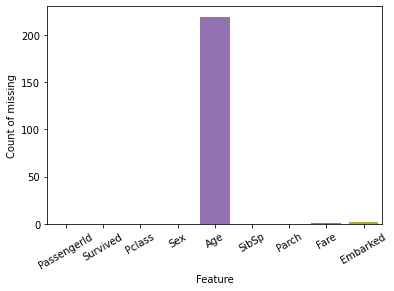

In [197]:
data_df = pd.DataFrame(my_train_valid_M1.isna().sum())
data_df.reset_index(inplace = True)
data_df.columns = ["Feature","Count of missing"]
plt.xticks(rotation=30)
sns.barplot(x = "Feature",y ="Count of missing", data=data_df)

In [198]:
print(my_train_valid_M1.shape)

(1100, 9)


In [199]:
'''Since there are some of Embarked is unknown, I will replace NA to U (Unknown)'''
my_train_valid_M1 = my_train_valid_M1.fillna(value={"Embarked":"U"})

In [200]:
my_train_valid_M1.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            219
SibSp            0
Parch            0
Fare             1
Embarked         0
dtype: int64

86.48016286764705 20.525851555555555 13.477033720930232


<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

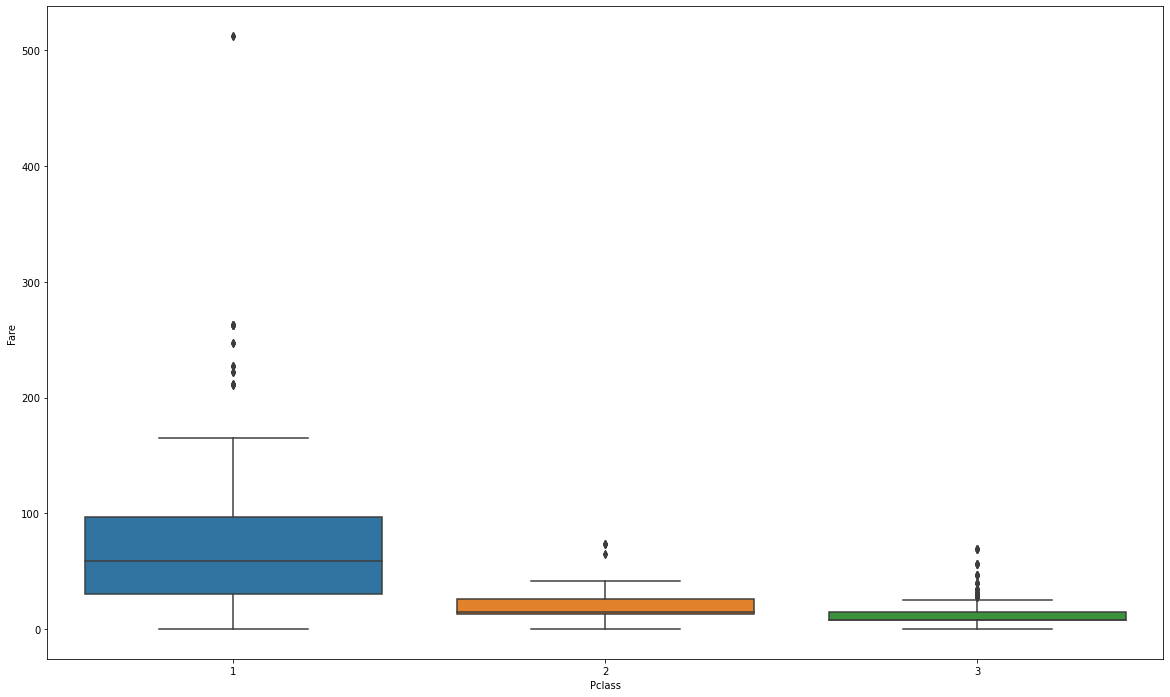

In [201]:
'''Fare may depend on Pclass, replace the Fare with the mean of fare correspond to Pclass'''
print(my_train_valid_M1[my_train_valid_M1["Pclass"] == 1]["Fare"].mean(),
      my_train_valid_M1[my_train_valid_M1["Pclass"] == 2]["Fare"].mean(),
      my_train_valid_M1[my_train_valid_M1["Pclass"] == 3]["Fare"].mean()
)
##Save it later because we need this for test set
AvgFare_Pclass = [my_train_valid_M1[my_train_valid_M1["Pclass"] == 1]["Fare"].mean(),
                  my_train_valid_M1[my_train_valid_M1["Pclass"] == 2]["Fare"].mean(),
                  my_train_valid_M1[my_train_valid_M1["Pclass"] == 3]["Fare"].mean()]
plt.figure(figsize=(20, 12))
sns.boxplot(x='Pclass', y='Fare', data=my_train_valid_M1)

In [202]:
AvgFare_Pclass

[86.48016286764705, 20.525851555555555, 13.477033720930232]

In [203]:
'''Replace NA in Fare'''
def replace_Fare_M1(df):
    print(df.index)
    for i in df.index:
        Pclass = int(df.loc[i,'Pclass'])-1
        Fare = df.loc[i,'Fare']
        df.at[i,"Fare_na"] = np.isnan(Fare)
        if np.isnan(Fare):
            #print(i,Pclass,Fare,np.isnan(Fare))
            #print(AvgFare_Pclass[int(Pclass)])
            df.at[i,'Fare'] = AvgFare_Pclass[Pclass]
    return df

In [204]:
my_train_valid_M1 = replace_Fare_M1(my_train_valid_M1)

RangeIndex(start=0, stop=1100, step=1)


In [205]:
my_train_valid_M1.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            219
SibSp            0
Parch            0
Fare             0
Embarked         0
Fare_na          0
dtype: int64

38.54646808510638 29.854644549763034 25.070689655172412


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

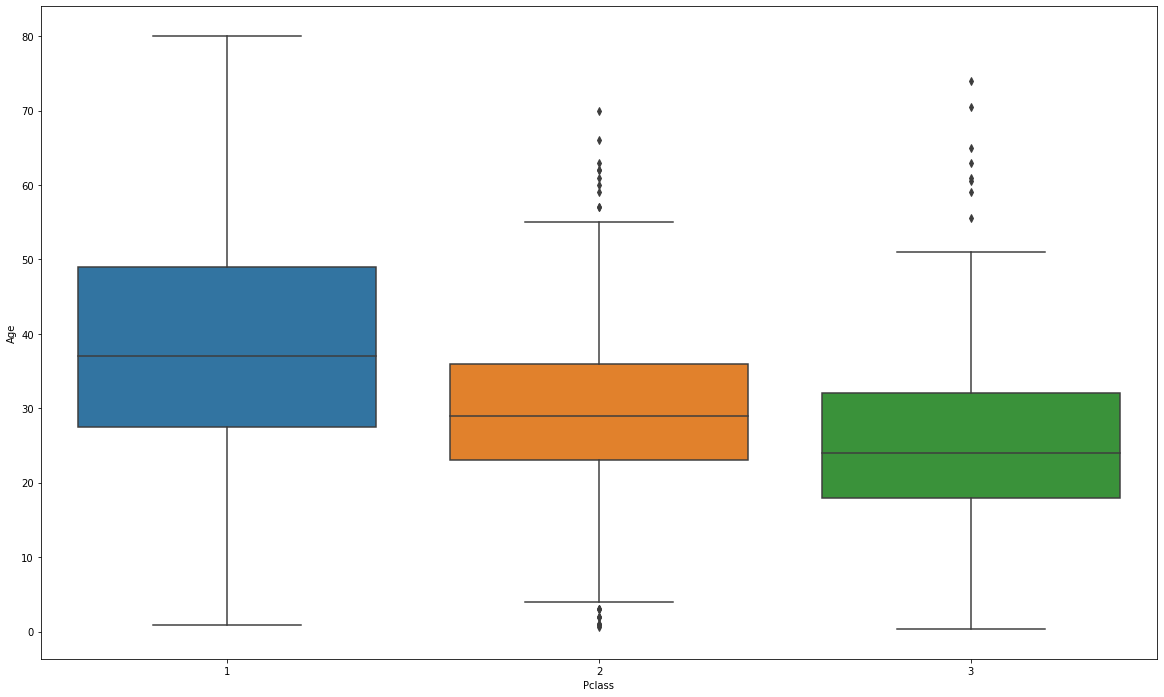

In [206]:
'''Age may depend on Pclass as well, because people can afford higher price along with the growth of the age '''
print(my_train_valid_M1[my_train_valid_M1["Pclass"] == 1]["Age"].mean(),
      my_train_valid_M1[my_train_valid_M1["Pclass"] == 2]["Age"].mean(),
      my_train_valid_M1[my_train_valid_M1["Pclass"] == 3]["Age"].mean()
)
##Save it later because we need this for test set
AvgAge_Pclass = [my_train_valid_M1[my_train_valid_M1["Pclass"] == 1]["Age"].mean(),
                  my_train_valid_M1[my_train_valid_M1["Pclass"] == 2]["Age"].mean(),
                  my_train_valid_M1[my_train_valid_M1["Pclass"] == 3]["Age"].mean()]
plt.figure(figsize=(20, 12))
sns.boxplot(x='Pclass', y='Age', data=my_train_valid_M1)

In [207]:
AvgAge_Pclass

[38.54646808510638, 29.854644549763034, 25.070689655172412]

In [208]:
'''Replace NA in Age'''
def replace_Age_M1(df):
    print(df.index)
    for i in df.index:
        Pclass = int(df.loc[i,'Pclass'])-1
        Age = df.loc[i,'Age']
        df.at[i,"Age_na"] = np.isnan(Age)
        if np.isnan(Age):
            #print(i,Pclass,Age,np.isnan(Age))
            #print(AvgAge_Pclass[int(Pclass)])
            df.at[i,'Age'] = AvgAge_Pclass[Pclass]
    return df

In [209]:
my_train_valid_M1 = replace_Age_M1(my_train_valid_M1)

RangeIndex(start=0, stop=1100, step=1)


In [210]:
my_train_valid_M1.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Fare_na        0
Age_na         0
dtype: int64

In [211]:
my_train_valid_M1.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_na,Age_na
0,1,0,3,male,22.0,1,0,7.2500,S,False,False
1,2,1,1,female,38.0,1,0,71.2833,C,False,False
2,3,1,3,female,26.0,0,0,7.9250,S,False,False
3,4,1,1,female,35.0,1,0,53.1000,S,False,False
4,5,0,3,male,35.0,0,0,8.0500,S,False,False


#### 2.2 Converting to Category from hwk1

In [212]:
my_train_valid_M1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1100 non-null   int64  
 1   Survived     1100 non-null   int64  
 2   Pclass       1100 non-null   int64  
 3   Sex          1100 non-null   object 
 4   Age          1100 non-null   float64
 5   SibSp        1100 non-null   int64  
 6   Parch        1100 non-null   int64  
 7   Fare         1100 non-null   float64
 8   Embarked     1100 non-null   object 
 9   Fare_na      1100 non-null   object 
 10  Age_na       1100 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 94.7+ KB


In [213]:
def str_to_cat(my_df):
    for p,q in my_df.items():
        if pd.api.types.is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [214]:
my_train_valid_M1 = str_to_cat(my_train_valid_M1)

In [215]:
my_train_valid_M1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1100 non-null   int64   
 1   Survived     1100 non-null   int64   
 2   Pclass       1100 non-null   int64   
 3   Sex          1100 non-null   category
 4   Age          1100 non-null   float64 
 5   SibSp        1100 non-null   int64   
 6   Parch        1100 non-null   int64   
 7   Fare         1100 non-null   float64 
 8   Embarked     1100 non-null   category
 9   Fare_na      1100 non-null   category
 10  Age_na       1100 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 65.0 KB


In [216]:
print(my_train_valid_M1.Embarked.cat.categories)
print(my_train_valid_M1.Sex.cat.categories)

Index(['C', 'Q', 'S', 'U'], dtype='object')
Index(['female', 'male'], dtype='object')


In [217]:
def mydf_to_nums(my_df, feature,null_status):
    if not pd.api.types.is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1

def mydf_preprocessor(my_df):
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    return my_df

In [218]:
my_train_valid_M1 = mydf_preprocessor(my_train_valid_M1)

In [219]:
my_train_valid_M1.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_na,Age_na
0,1,0,3,2,22.0,1,0,7.2500,3,1,1
1,2,1,1,1,38.0,1,0,71.2833,1,1,1
2,3,1,3,1,26.0,0,0,7.9250,3,1,1
3,4,1,1,1,35.0,1,0,53.1000,3,1,1
4,5,0,3,2,35.0,0,0,8.0500,3,1,1


In [220]:
X_Con = my_train_valid_M1[['Age', 'Fare']]
X_Cat = my_train_valid_M1.drop(X_Con,axis = 1)
scaler = sklearn.preprocessing.StandardScaler().fit(X_Con)
X_con_sc = pd.DataFrame(scaler.transform(X_Con))
X_con_sc.columns = ["Age","Fare"]

In [221]:
X_con_sc.head(2)

,Age,Fare
0,-0.560804,-0.502134
1,0.654798,0.747969


In [222]:
df_list = [X_Cat,X_con_sc]
my_train_valid_M1 = pd.concat(df_list,axis=1)
print(my_train_valid_M1.shape)
my_train_valid_M1.head()

(1100, 11)


,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,Fare_na,Age_na,Age,Fare
0,1,0,3,2,1,0,3,1,1,-0.560804,-0.502134
1,2,1,1,1,1,0,1,1,1,0.654798,0.747969
2,3,1,3,1,0,0,3,1,1,-0.256904,-0.488956
3,4,1,1,1,1,0,3,1,1,0.426872,0.392982
4,5,0,3,2,0,0,3,1,1,0.426872,-0.486516


In [223]:
y_train_valid_M1 = my_train_valid_M1['Survived']
X_train_valid_M1 = my_train_valid_M1.drop(columns=['Survived'],axis=1)
print(X_train_valid_M1.shape,y_train_valid_M1.shape)

(1100, 10) (1100,)


In [224]:
X_train_M1,X_valid_M1 = mydf_splitter(X_train_valid_M1,900)
y_train_M1,y_valid_M1 = mydf_splitter(y_train_valid_M1 ,900)
print(X_train_M1.shape,y_train_M1.shape,
      X_valid_M1.shape,y_valid_M1.shape)

(900, 10) (900,) (200, 10) (200,)


#### 2.3 Training and validation

In [225]:
#Build first model after imputation by using mean value
model_1 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000,max_features = 0.25,
                               bootstrap = True)

In [226]:
model_1.fit(X_train_M1, y_train_M1)

RandomForestClassifier(max_features=0.25, n_estimators=1000, n_jobs=-1)

In [227]:
#check the accuracy on validation set
y_pred_M1 = model_1.predict(X_valid_M1)
accuracy_score(y_valid_M1, y_pred_M1)

0.545

In [228]:
print(classification_report(y_valid_M1, y_pred_M1))

              precision    recall  f1-score   support

           0       0.68      0.59      0.63       132
           1       0.36      0.46      0.41        68

    accuracy                           0.55       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.57      0.55      0.55       200



In [229]:
c_mat = confusion_matrix(y_valid_M1, y_pred_M1)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.head(2)

,0,1
0,78,54
1,37,31


In [230]:
c_mat_df.columns = ["Did not Survive","Survived"]
c_mat_df.index = ["Did not Survive","Survived"]
c_mat_df = c_mat_df.T
c_mat_df

,Did not Survive,Survived
Did not Survive,78,37
Survived,54,31


Text(50.99999999999999, 0.5, 'Predicted')

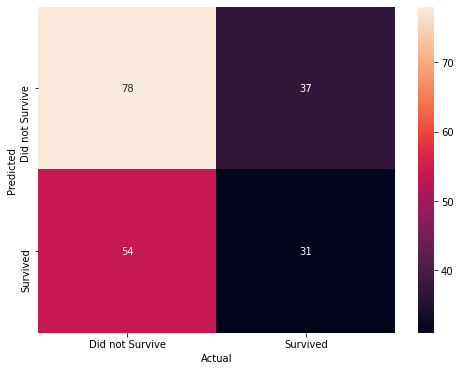

In [231]:
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

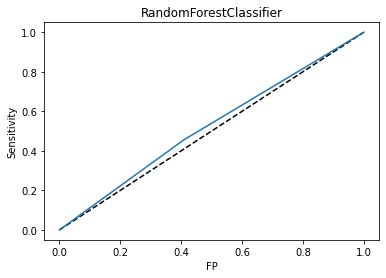

In [232]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_valid_M1, y_pred_M1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
plt.title('RandomForestClassifier')
plt.show()

## 3.Imputation Method 2 - Imputation Using (Most Frequent) or (Zero/Constant) Values:

In [233]:
#Starting my second imputation by using most frequent values
my_train_valid_M2 = my_train_valid
my_test_M2 = my_test
print(my_train_valid_M2.shape)
print(my_test_M2.shape)

(1100, 9)
(209, 9)


In [234]:
my_train_valid_M2.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            219
SibSp            0
Parch            0
Fare             1
Embarked         2
dtype: int64

<AxesSubplot:xlabel='Feature', ylabel='Count of missing'>

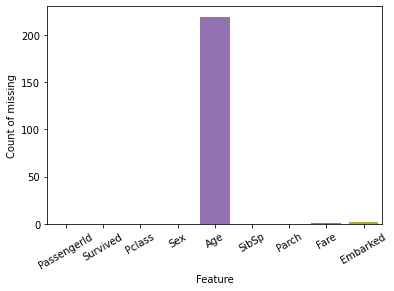

In [235]:
data_df = pd.DataFrame(my_train_valid_M2.isna().sum())
data_df.reset_index(inplace = True)
data_df.columns = ["Feature","Count of missing"]
plt.xticks(rotation=30)
sns.barplot(x = "Feature",y ="Count of missing", data=data_df)

In [236]:
'''Since there are some of Embarked is unknown, I will replace NA to U (Unknown)'''
my_train_valid_M2 = my_train_valid_M2.fillna(value={"Embarked":"U"})

In [237]:
my_train_valid_M2.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            219
SibSp            0
Parch            0
Fare             1
Embarked         0
dtype: int64

<AxesSubplot:xlabel='count', ylabel='Fare'>

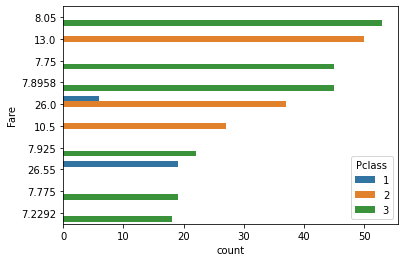

In [238]:
#Finding the most frequent values
sns.countplot(y="Fare", hue="Pclass", data=my_train_valid_M2,
              order=my_train_valid_M2.Fare.value_counts().iloc[:10].index)

<AxesSubplot:xlabel='count', ylabel='Fare'>

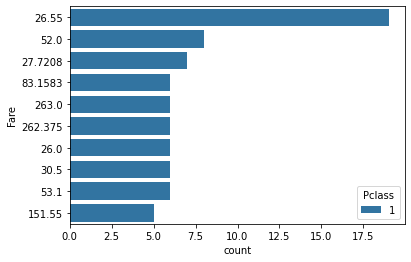

In [239]:
#Finding the most frequent value of fare when pclass is 1
sns.countplot(y="Fare", hue="Pclass", data=my_train_valid_M2[my_train_valid_M2["Pclass"] == 1], 
             order=my_train_valid_M2[my_train_valid_M2["Pclass"] == 1].Fare.value_counts().iloc[:10].index)

<AxesSubplot:xlabel='count', ylabel='Fare'>

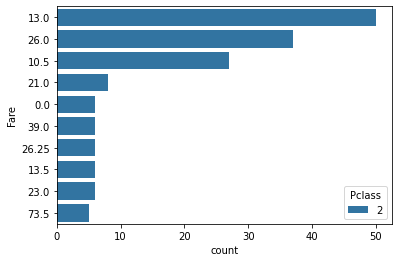

In [240]:
#Finding the most frequent value of fare when pclass is 2
sns.countplot(y="Fare", hue="Pclass", data=my_train_valid_M2[my_train_valid_M2["Pclass"] == 2], 
             order=my_train_valid_M2[my_train_valid_M2["Pclass"] == 2].Fare.value_counts().iloc[:10].index)

<AxesSubplot:xlabel='count', ylabel='Fare'>

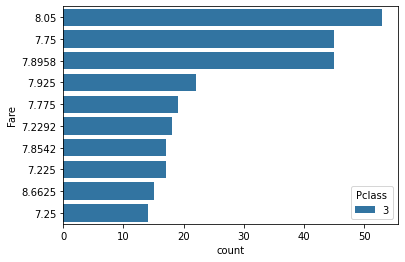

In [241]:
#Finding the most frequent value of fare when pclass is 3
sns.countplot(y="Fare", hue="Pclass", data=my_train_valid_M2[my_train_valid_M2["Pclass"] == 3],
             order=my_train_valid_M2[my_train_valid_M2["Pclass"] == 3].Fare.value_counts().iloc[:10].index)

In [242]:
'''Find the most freq in Fare and replace'''
def replace_Fare_M2(df):
    Pclass_1 =df[df["Pclass"] == 1].Fare.value_counts().iloc[:1].index.tolist()[0]
    Pclass_2 = df[df["Pclass"] == 2].Fare.value_counts().iloc[:1].index.tolist()[0]
    Pclass_3 = df[df["Pclass"] == 3].Fare.value_counts().iloc[:1].index.tolist()[0]
    FareFrq_Pclass = [Pclass_1,Pclass_2,Pclass_3]
    #print(FareFrq_Pclass)
    print(df.index)
    for i in df.index:
        Pclass = int(df.loc[i,'Pclass'])-1
        Fare = df.loc[i,'Fare']
        df.at[i,"Fare_na"] = np.isnan(Fare)
        if np.isnan(Fare):
            df.at[i,'Fare'] = FareFrq_Pclass[Pclass]
    return df,FareFrq_Pclass

In [243]:
my_train_valid_M2,FareFrq_Pclass=replace_Fare_M2(my_train_valid_M2)

RangeIndex(start=0, stop=1100, step=1)


In [244]:
#The most freq values of fare in three different pclasses
FareFrq_Pclass

[26.55, 13.0, 8.05]

In [245]:
my_train_valid_M2.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            219
SibSp            0
Parch            0
Fare             0
Embarked         0
Fare_na          0
dtype: int64

<AxesSubplot:xlabel='count', ylabel='Age'>

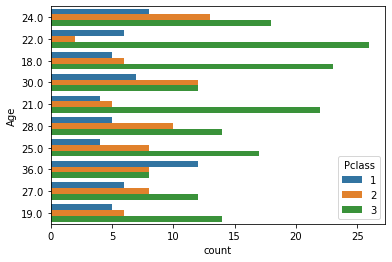

In [246]:
#Finding the most frequent values of age
sns.countplot(y="Age", hue="Pclass", data=my_train_valid_M2,
              order=my_train_valid_M2.Age.value_counts().iloc[:10].index)

<AxesSubplot:xlabel='count', ylabel='Age'>

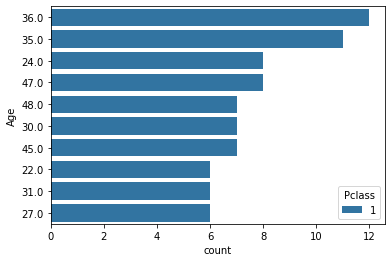

In [247]:
#Finding the most frequent value of age when pclass is 1
sns.countplot(y="Age", hue="Pclass", data=my_train_valid_M2[my_train_valid_M2["Pclass"] == 1], 
             order=my_train_valid_M2[my_train_valid_M2["Pclass"] == 1].Age.value_counts().iloc[:10].index)

<AxesSubplot:xlabel='count', ylabel='Age'>

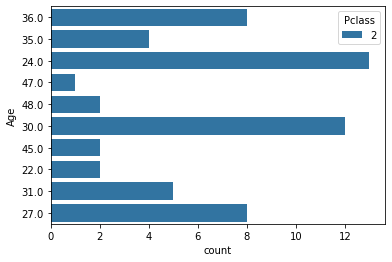

In [248]:
#Finding the most frequent value of age when pclass is 2
sns.countplot(y="Age", hue="Pclass", data=my_train_valid_M2[my_train_valid_M2["Pclass"] == 2], 
             order=my_train_valid_M2[my_train_valid_M2["Pclass"] == 1].Age.value_counts().iloc[:10].index)

<AxesSubplot:xlabel='count', ylabel='Age'>

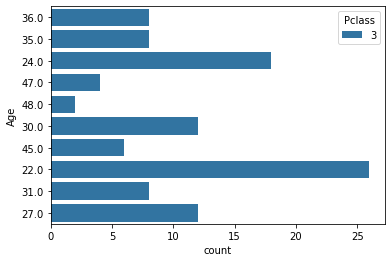

In [249]:
#Finding the most frequent value of age when pclass is 3
sns.countplot(y="Age", hue="Pclass", data=my_train_valid_M2[my_train_valid_M2["Pclass"] == 3], 
             order=my_train_valid_M2[my_train_valid_M2["Pclass"] == 1].Age.value_counts().iloc[:10].index)

In [250]:
'''Find the most freq in Age and replace'''
def replace_Age_M2(df):
    Pclass_1 =df[df["Pclass"] == 1].Age.value_counts().iloc[:1].index.tolist()[0]
    Pclass_2 = df[df["Pclass"] == 2].Age.value_counts().iloc[:1].index.tolist()[0]
    Pclass_3 = df[df["Pclass"] == 3].Age.value_counts().iloc[:1].index.tolist()[0]
    AgeFrq_Pclass = [Pclass_1,Pclass_2,Pclass_3]
    #print(AgeFrq_Pclass)
    print(df.index)
    for i in df.index:
        Pclass = int(df.loc[i,'Pclass'])-1
        Age = df.loc[i,'Age']
        df.at[i,"Age_na"] = np.isnan(Age)
        if np.isnan(Age):
            df.at[i,'Age'] = AgeFrq_Pclass[Pclass]
    return df,AgeFrq_Pclass

In [251]:
my_train_valid_M2,AgeFrq_Pclass=replace_Age_M2(my_train_valid_M2)

RangeIndex(start=0, stop=1100, step=1)


In [252]:
#The most freq values of age in three different pclasses
AgeFrq_Pclass

[36.0, 24.0, 22.0]

In [253]:
my_train_valid_M2.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Fare_na        0
Age_na         0
dtype: int64

In [254]:
my_train_valid_M2.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_na,Age_na
0,1,0,3,male,22.0,1,0,7.2500,S,False,False
1,2,1,1,female,38.0,1,0,71.2833,C,False,False
2,3,1,3,female,26.0,0,0,7.9250,S,False,False
3,4,1,1,female,35.0,1,0,53.1000,S,False,False
4,5,0,3,male,35.0,0,0,8.0500,S,False,False


#### 3.2 Converting to Category from hwk1

In [255]:
my_train_valid_M2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1100 non-null   int64  
 1   Survived     1100 non-null   int64  
 2   Pclass       1100 non-null   int64  
 3   Sex          1100 non-null   object 
 4   Age          1100 non-null   float64
 5   SibSp        1100 non-null   int64  
 6   Parch        1100 non-null   int64  
 7   Fare         1100 non-null   float64
 8   Embarked     1100 non-null   object 
 9   Fare_na      1100 non-null   object 
 10  Age_na       1100 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 94.7+ KB


In [256]:
def str_to_cat(my_df):
    for p,q in my_df.items():
        if pd.api.types.is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [257]:
my_train_valid_M2 = str_to_cat(my_train_valid_M2)

In [258]:
my_train_valid_M2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1100 non-null   int64   
 1   Survived     1100 non-null   int64   
 2   Pclass       1100 non-null   int64   
 3   Sex          1100 non-null   category
 4   Age          1100 non-null   float64 
 5   SibSp        1100 non-null   int64   
 6   Parch        1100 non-null   int64   
 7   Fare         1100 non-null   float64 
 8   Embarked     1100 non-null   category
 9   Fare_na      1100 non-null   category
 10  Age_na       1100 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 65.0 KB


In [259]:
print(my_train_valid_M2.Embarked.cat.categories)
print(my_train_valid_M2.Sex.cat.categories)

Index(['C', 'Q', 'S', 'U'], dtype='object')
Index(['female', 'male'], dtype='object')


In [260]:
def mydf_to_nums(my_df, feature,null_status):
    if not pd.api.types.is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1

def mydf_preprocessor(my_df):
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    return my_df

In [261]:
my_train_valid_M2 = mydf_preprocessor(my_train_valid_M2)

In [262]:
my_train_valid_M2.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_na,Age_na
0,1,0,3,2,22.0,1,0,7.2500,3,1,1
1,2,1,1,1,38.0,1,0,71.2833,1,1,1
2,3,1,3,1,26.0,0,0,7.9250,3,1,1
3,4,1,1,1,35.0,1,0,53.1000,3,1,1
4,5,0,3,2,35.0,0,0,8.0500,3,1,1


In [263]:
X_Con = my_train_valid_M2[['Age', 'Fare']]
X_Cat = my_train_valid_M2.drop(X_Con,axis = 1)
scaler = sklearn.preprocessing.StandardScaler().fit(X_Con)
X_con_sc = pd.DataFrame(scaler.transform(X_Con))
X_con_sc.columns = ["Age","Fare"]

In [264]:
X_con_sc.head(2)

,Age,Fare
0,-0.507038,-0.502017
1,0.694425,0.748034


In [265]:
df_list = [X_Cat,X_con_sc]
my_train_valid_M2 = pd.concat(df_list,axis=1)
print(my_train_valid_M2.shape)
my_train_valid_M2.head()

(1100, 11)


,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,Fare_na,Age_na,Age,Fare
0,1,0,3,2,1,0,3,1,1,-0.507038,-0.502017
1,2,1,1,1,1,0,1,1,1,0.694425,0.748034
2,3,1,3,1,0,0,3,1,1,-0.206672,-0.488840
3,4,1,1,1,1,0,3,1,1,0.469151,0.393062
4,5,0,3,2,0,0,3,1,1,0.469151,-0.486400


In [266]:
y_train_valid_M2 = my_train_valid_M2['Survived']
X_train_valid_M2 = my_train_valid_M2.drop(columns=['Survived'],axis=1)
print(X_train_valid_M2.shape,y_train_valid_M2.shape)

(1100, 10) (1100,)


In [267]:
X_train_M2,X_valid_M2 = mydf_splitter(X_train_valid_M2,900)
y_train_M2,y_valid_M2 = mydf_splitter(y_train_valid_M2 ,900)
print(X_train_M2.shape,y_train_M2.shape,
      X_valid_M2.shape,y_valid_M2.shape)

(900, 10) (900,) (200, 10) (200,)


#### 3.3 Training and validation

In [268]:
#Build first model after imputation by using most frquence
model_2 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000,max_features = 0.25,
                               bootstrap = True)

In [269]:
model_2.fit(X_train_M2, y_train_M2)

RandomForestClassifier(max_features=0.25, n_estimators=1000, n_jobs=-1)

In [270]:
#check the accuracy
y_pred_M2 = model_1.predict(X_valid_M2)
accuracy_score(y_valid_M2, y_pred_M2)

0.54

In [271]:
print(classification_report(y_valid_M2, y_pred_M2))

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       132
           1       0.36      0.44      0.39        68

    accuracy                           0.54       200
   macro avg       0.51      0.52      0.51       200
weighted avg       0.57      0.54      0.55       200



In [272]:
c_mat = confusion_matrix(y_valid_M2, y_pred_M2)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.head(2)

,0,1
0,78,54
1,38,30


In [273]:
c_mat_df.columns = ["Did not Survive","Survived"]
c_mat_df.index = ["Did not Survive","Survived"]
c_mat_df = c_mat_df.T
c_mat_df

,Did not Survive,Survived
Did not Survive,78,38
Survived,54,30


Text(50.99999999999999, 0.5, 'Predicted')

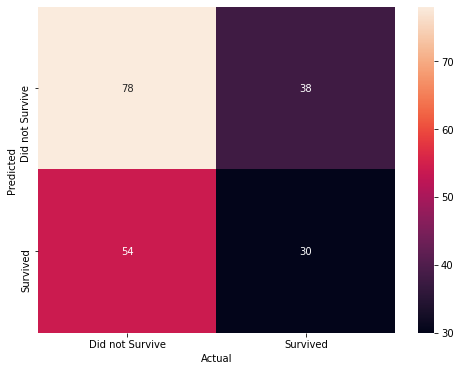

In [274]:
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

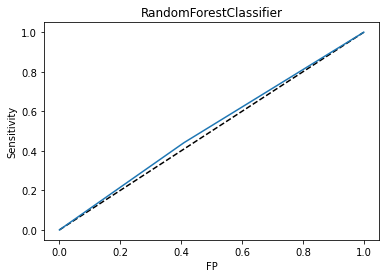

In [275]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_valid_M2, y_pred_M2)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
plt.title('RandomForestClassifier')
plt.show()

## 4.Imputation Method 3 - Imputation Using k-NN:

In [276]:
#Third imputation with KNN
my_train_valid_M3 = my_train_valid
my_test_M3 = my_test
print(my_train_valid_M3.shape)
print(my_test_M3.shape)

(1100, 9)
(209, 9)


In [277]:
my_train_valid_M3.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            219
SibSp            0
Parch            0
Fare             1
Embarked         2
dtype: int64

<AxesSubplot:xlabel='Feature', ylabel='Count of missing'>

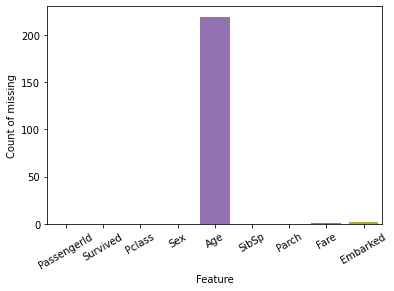

In [278]:
data_df = pd.DataFrame(my_train_valid_M3.isna().sum())
data_df.reset_index(inplace = True)
data_df.columns = ["Feature","Count of missing"]
plt.xticks(rotation=30)
sns.barplot(x = "Feature",y ="Count of missing", data=data_df)

In [279]:
my_train_valid_M3.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            219
SibSp            0
Parch            0
Fare             1
Embarked         2
dtype: int64

In [280]:
'''Since there are some of Embarked is unknown, I will replace NA to U (Unknown)'''
my_train_valid_M3 = my_train_valid_M3.fillna(value={"Embarked":"U"})

In [281]:
my_train_valid_M3.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            219
SibSp            0
Parch            0
Fare             1
Embarked         0
dtype: int64

In [282]:
#since we will imputate by KNN, we have to know which contains nan value before imputation
def pre_replace(df):
    print(df.index)
    for i in df.index:
        Fare = df.loc[i,'Fare']
        Age = df.loc[i,'Fare']
        df.at[i,"Fare_na"] = np.isnan(Fare)
        df.at[i,"Age_na"] = np.isnan(Age)
    return df

In [283]:
my_train_valid_M3 = pre_replace(my_train_valid_M3)

RangeIndex(start=0, stop=1100, step=1)


In [284]:
my_train_valid_M3.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_na,Age_na
0,1,0,3,male,22.0,1,0,7.2500,S,False,False
1,2,1,1,female,38.0,1,0,71.2833,C,False,False
2,3,1,3,female,26.0,0,0,7.9250,S,False,False
3,4,1,1,female,35.0,1,0,53.1000,S,False,False
4,5,0,3,male,35.0,0,0,8.0500,S,False,False


In [285]:
def str_to_cat(my_df):
    for p,q in my_df.items():
        if pd.api.types.is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [286]:
my_train_valid_M3 = str_to_cat(my_train_valid_M3)

In [287]:
my_train_valid_M3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1100 non-null   int64   
 1   Survived     1100 non-null   int64   
 2   Pclass       1100 non-null   int64   
 3   Sex          1100 non-null   category
 4   Age          881 non-null    float64 
 5   SibSp        1100 non-null   int64   
 6   Parch        1100 non-null   int64   
 7   Fare         1099 non-null   float64 
 8   Embarked     1100 non-null   category
 9   Fare_na      1100 non-null   category
 10  Age_na       1100 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 65.0 KB


In [288]:
def mydf_to_nums(my_df, feature,null_status):
    if not pd.api.types.is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1

def mydf_preprocessor(my_df):
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    return my_df

In [289]:
my_train_valid_M3 = mydf_preprocessor(my_train_valid_M3)

In [290]:
my_train_valid_M3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1100 non-null   int64  
 1   Survived     1100 non-null   int64  
 2   Pclass       1100 non-null   int64  
 3   Sex          1100 non-null   int8   
 4   Age          881 non-null    float64
 5   SibSp        1100 non-null   int64  
 6   Parch        1100 non-null   int64  
 7   Fare         1099 non-null   float64
 8   Embarked     1100 non-null   int8   
 9   Fare_na      1100 non-null   int8   
 10  Age_na       1100 non-null   int8   
dtypes: float64(2), int64(5), int8(4)
memory usage: 64.6 KB


In [291]:
#Knn predict age and fare for dataset
from sklearn.impute import KNNImputer

imputer = KNNImputer()
age_fare = imputer.fit_transform(my_train_valid_M3[['Age',"Fare"]])

In [292]:
age_fare  = pd.DataFrame(data=age_fare)

In [293]:
age_fare

,0,1
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500
...,...,...
1095,25.0,10.5000
1096,49.6,25.7417
1097,35.0,7.7500
1098,24.0,10.5000


In [294]:
#replace imputated columns
my_train_valid_M3.Age = age_fare[0]
my_train_valid_M3.Fare = age_fare[1]

In [295]:
my_train_valid_M3.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_na,Age_na
0,1,0,3,2,22.0,1,0,7.2500,3,1,1
1,2,1,1,1,38.0,1,0,71.2833,1,1,1
2,3,1,3,1,26.0,0,0,7.9250,3,1,1
3,4,1,1,1,35.0,1,0,53.1000,3,1,1
4,5,0,3,2,35.0,0,0,8.0500,3,1,1


In [296]:
my_train_valid_M3.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Fare_na        0
Age_na         0
dtype: int64

In [297]:
X_Con = my_train_valid_M3[['Age', 'Fare']]
X_Cat = my_train_valid_M3.drop(X_Con,axis = 1)
scaler = sklearn.preprocessing.StandardScaler().fit(X_Con)
X_con_sc = pd.DataFrame(scaler.transform(X_Con))
X_con_sc.columns = ["Age","Fare"]

In [298]:
X_con_sc.head(2)

,Age,Fare
0,-0.597565,-0.503299
1,0.601822,0.745978


In [299]:
df_list = [X_Cat,X_con_sc]
my_train_valid_M3 = pd.concat(df_list,axis=1)
print(my_train_valid_M3.shape)
my_train_valid_M3.head()

(1100, 11)


,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,Fare_na,Age_na,Age,Fare
0,1,0,3,2,1,0,3,1,1,-0.597565,-0.503299
1,2,1,1,1,1,0,1,1,1,0.601822,0.745978
2,3,1,3,1,0,0,3,1,1,-0.297718,-0.490130
3,4,1,1,1,1,0,3,1,1,0.376937,0.391225
4,5,0,3,2,0,0,3,1,1,0.376937,-0.487691


In [300]:
y_train_valid_M3 = my_train_valid_M3['Survived']
X_train_valid_M3 = my_train_valid_M3.drop(columns=['Survived'],axis=1)
print(X_train_valid_M3.shape,y_train_valid_M3.shape)

(1100, 10) (1100,)


In [301]:
X_train_M3,X_valid_M3 = mydf_splitter(X_train_valid_M3,900)
y_train_M3,y_valid_M3 = mydf_splitter(y_train_valid_M3 ,900)
print(X_train_M3.shape,y_train_M3.shape,
      X_valid_M3.shape,y_valid_M3.shape)

(900, 10) (900,) (200, 10) (200,)


#### 4.2 Training and validation

In [302]:
#Build model with knn imputation
model_3 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000,max_features = 0.25,
                               bootstrap = True)

In [ ]:
model_3.fit(X_train_M3, y_train_M3)

In [ ]:
y_pred_M3 = model_1.predict(X_valid_M3)
accuracy_score(y_valid_M3, y_pred_M3)

In [ ]:
print(classification_report(y_valid_M3, y_pred_M3))

In [ ]:
c_mat = confusion_matrix(y_valid_M3, y_pred_M3)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.head(2)

In [ ]:
c_mat_df.columns = ["Did not Survive","Survived"]
c_mat_df.index = ["Did not Survive","Survived"]
c_mat_df = c_mat_df.T
c_mat_df

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [ ]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_valid_M3, y_pred_M3)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
plt.title('RandomForestClassifier')
plt.show()

## 5.Models with test set

#### 5.1 Test set Cleaning

In [ ]:
my_test_M1 = my_test_M1.fillna(value={"Embarked":"U"})

In [ ]:
my_test_M1.isna().sum()

In [ ]:
#replace age and dare based on the rule of model 2 - mean value
def replace_test_M1(df):
    print(df.index)
    for i in df.index:
        Pclass = int(df.loc[i,'Pclass'])-1
        Fare = df.loc[i,'Fare']
        Age = df.loc[i,'Age']
        df.at[i,"Fare_na"] = np.isnan(Fare)
        df.at[i,"Age_na"] = np.isnan(Fare)
        if np.isnan(Fare):
            df.at[i,'Fare'] = AvgFare_Pclass[Pclass]
        if np.isnan(Age):
            df.at[i,'Age'] = AvgAge_Pclass[Pclass]
    return df

In [ ]:
my_test_M1=replace_test_M1(my_test_M1)

In [ ]:
my_test_M1.isna().sum()

In [ ]:
my_test_M1.info()

In [ ]:
my_test_M1 = str_to_cat(my_test_M1)

In [ ]:
my_test_M1.info()

In [ ]:
print(my_test_M1.Embarked.cat.categories)
print(my_test_M1.Sex.cat.categories)

In [ ]:
my_test_M1 = mydf_preprocessor(my_test_M1)

In [ ]:
my_test_M1.head()

In [ ]:
X_Con = my_test_M1[['Age', 'Fare']]
X_Cat = my_test_M1.drop(X_Con,axis = 1)
scaler = sklearn.preprocessing.StandardScaler().fit(X_Con)
X_con_sc = pd.DataFrame(scaler.transform(X_Con))
X_con_sc.columns = ["Age","Fare"]

In [ ]:
X_con_sc.head(2)

In [ ]:
df_list = [X_Cat,X_con_sc]
my_test_M1 = pd.concat(df_list,axis=1)
print(my_test_M1.shape)
my_test_M1.head()

In [ ]:
#Creating the test set for first model
y_my_test_M1 = my_test_M1['Survived']
X_my_test_M1 = my_test_M1.drop(columns=['Survived'],axis=1)
print(X_my_test_M1.shape,y_my_test_M1.shape)

In [ ]:
my_test_M2 = my_test_M2.fillna(value={"Embarked":"U"})

In [ ]:
my_test_M2.isna().sum()

In [ ]:
#replace age and dare based on the rule of model 2 - most freq
def replace_test_M2(df):
    print(df.index)
    for i in df.index:
        Pclass = int(df.loc[i,'Pclass'])-1
        Fare = df.loc[i,'Fare']
        Age = df.loc[i,'Age']
        df.at[i,"Fare_na"] = np.isnan(Fare)
        df.at[i,"Age_na"] = np.isnan(Fare)
        if np.isnan(Fare):
            df.at[i,'Fare'] = FareFrq_Pclass[Pclass]
        if np.isnan(Age):
            df.at[i,'Age'] = AgeFrq_Pclass[Pclass]
    return df

In [ ]:
my_test_M2=replace_test_M2(my_test_M2)

In [ ]:
my_test_M2.isna().sum()

In [ ]:
my_test_M2.info()

In [ ]:
my_test_M2 = str_to_cat(my_test_M2)

In [ ]:
my_test_M2.info()

In [ ]:
print(my_test_M2.Embarked.cat.categories)
print(my_test_M2.Sex.cat.categories)

In [ ]:
my_test_M2 = mydf_preprocessor(my_test_M2)

In [ ]:
my_test_M2.head()

In [ ]:
X_Con = my_test_M2[['Age', 'Fare']]
X_Cat = my_test_M2.drop(X_Con,axis = 1)
scaler = sklearn.preprocessing.StandardScaler().fit(X_Con)
X_con_sc = pd.DataFrame(scaler.transform(X_Con))
X_con_sc.columns = ["Age","Fare"]

In [ ]:
X_con_sc.head(2)

In [ ]:
df_list = [X_Cat,X_con_sc]
my_test_M2 = pd.concat(df_list,axis=1)
print(my_test_M2.shape)
my_test_M2.head()

In [ ]:
#Creating the test set for second model
y_my_test_M2 = my_test_M2['Survived']
X_my_test_M2 = my_test_M2.drop(columns=['Survived'],axis=1)
print(X_my_test_M2.shape,y_my_test_M2.shape)

In [ ]:
my_test_M3 = my_test_M3.fillna(value={"Embarked":"U"})

In [ ]:
my_test_M3.isna().sum()

In [ ]:
my_test_M3 = pre_replace(my_test_M3)

In [ ]:
my_test_M3.isna().sum()

In [ ]:
my_test_M3 = str_to_cat(my_test_M3)

In [ ]:
my_test_M3.info()

In [ ]:
my_test_M3 = mydf_preprocessor(my_test_M3)

In [ ]:
my_test_M3.info()

In [ ]:
#using knn to predict age and fare for test set
age_fare = imputer.fit_transform(my_test_M3[['Age',"Fare"]])

In [ ]:
age_fare  = pd.DataFrame(data=age_fare)

In [ ]:
age_fare

In [ ]:
#replace age and fare into third test set
my_test_M3.Age = age_fare[0]
my_test_M3.Fare = age_fare[1]

In [ ]:
my_test_M3.head()

In [ ]:
my_test_M3.isna().sum()

In [ ]:
X_Con = my_test_M3[['Age', 'Fare']]
X_Cat = my_test_M3.drop(X_Con,axis = 1)
scaler = sklearn.preprocessing.StandardScaler().fit(X_Con)
X_con_sc = pd.DataFrame(scaler.transform(X_Con))
X_con_sc.columns = ["Age","Fare"]

In [ ]:
X_con_sc.head(2)

In [ ]:
df_list = [X_Cat,X_con_sc]
my_test_M3 = pd.concat(df_list,axis=1)
print(my_test_M3.shape)
my_test_M3.head()

In [ ]:
y_my_test_M3 = my_test_M3['Survived']
X_my_test_M3 = my_test_M3.drop(columns=['Survived'],axis=1)
print(X_my_test_M3.shape,y_my_test_M3.shape)

#### 5.2 Evaluating Test set Accuracy

In [ ]:
#model_1
model_1 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000,max_features = 0.25,
                               bootstrap = True)
model_1.fit(X_train_valid_M1, y_train_valid_M1)
#model_2
model_2 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000,max_features = 0.25,
                               bootstrap = True)
model_2.fit(X_train_valid_M2, y_train_valid_M2)
#model_3
model_3 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000,max_features = 0.25,
                               bootstrap = True)
model_3.fit(X_train_valid_M3, y_train_valid_M3)

In [ ]:
y_pred_M1 = model_1.predict(X_my_test_M1)
y_pred_M2 = model_2.predict(X_my_test_M2)
y_pred_M3 = model_3.predict(X_my_test_M3)

In [ ]:
#accuracy of first model
print(accuracy_score(y_pred_M1,y_my_test_M1))
print(classification_report(y_pred_M1,y_my_test_M1))

In [ ]:
c_mat = confusion_matrix(y_pred_M1,y_my_test_M1)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.columns = ["Did not Survive","Survived"]
c_mat_df.index = ["Did not Survive","Survived"]
c_mat_df = c_mat_df.T
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [ ]:
#accuracy of second model
print(accuracy_score(y_pred_M2,y_my_test_M2))
print(classification_report(y_pred_M2,y_my_test_M2))

In [ ]:
c_mat = confusion_matrix(y_pred_M2,y_my_test_M2)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.columns = ["Did not Survive","Survived"]
c_mat_df.index = ["Did not Survive","Survived"]
c_mat_df = c_mat_df.T
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [ ]:
#accuracy of third model
print(accuracy_score(y_pred_M3,y_my_test_M3))
print(classification_report(y_pred_M3,y_my_test_M3))

In [ ]:
c_mat = confusion_matrix(y_pred_M3,y_my_test_M3)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.columns = ["Did not Survive","Survived"]
c_mat_df.index = ["Did not Survive","Survived"]
c_mat_df = c_mat_df.T
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [ ]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_pred_M1,y_my_test_M1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
plt.title('RandomForestClassifier_Model1')
plt.show()

In [ ]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_pred_M2,y_my_test_M2)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
plt.title('RandomForestClassifier_Model2')
plt.show()

In [ ]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_pred_M3,y_my_test_M3)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
plt.title('RandomForestClassifier_Model3')
plt.show()

## 6.Conclusion

In [ ]:
print('The Accuracy of Imputation Using Mean Values: '+ str(accuracy_score(y_pred_M1,y_my_test_M1)) +'\n'+
'The Accuracy of Imputation Using Most Frequent Values: '+ str(accuracy_score(y_pred_M2,y_my_test_M2)) +'\n'+
'The Accuracy of Imputation Using k-NN: '+ str(accuracy_score(y_pred_M3,y_my_test_M3)))

In [ ]:
'''Based on the results of three different imputations, KNN-imputation has the best accuracy'''